# Homework 3 | Survival Analysis

By Tatev Stepanyan

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter
from lifelines.utils import concordance_index
from sklearn.impute import SimpleImputer

### Configurations

In [2]:
DATA_PATH = "data/telco.csv"
CLV_HORIZON_MONTHS = 36
ANNUAL_DISCOUNT_RATE = 0.1
AVG_MONTHLY_MARGIN = 10
PV_LABEL = "CLV"
PVAL_THRESHOLD = 0.05

### Helper functions

#### Data-related

In [3]:
def load_data(path):
    df = pd.read_csv(path)
    return df


def explore_data(df):
    print("\nData Exploration:")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nDataset info:")
    print(df.info())
    print("\nSummary statistics for numeric columns:")
    print(df.describe().T)
    print("\nNumber of unique values per column:")
    print(df.nunique())
    print("\nUnique values in column 'churn':")
    print(df['churn'].unique())


def clean_churn_col(df):
    """
    Convert churn-like column to binary 1 (event)/0 (censored)
    """
    return df["churn"].map(lambda x: 1 if str(x).strip().lower() == "yes" else 0).astype(int)


def preprocess(df):
    """
    Preprocess the data:
    - convert churn column to binary
    - impute missing numeric values
    - one-hot encode categorical columns
    """
    df = df.copy()

    if "ID" in df.columns:
        df = df.drop(columns=["ID"])

    df["churn"] = clean_churn_col(df)

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c not in ["tenure", "churn"]]
    if num_cols:
        imputer = SimpleImputer(strategy="median")
        df[num_cols] = imputer.fit_transform(df[num_cols])

    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    cat_cols = [c for c in cat_cols if df[c].nunique() > 1 and c != "churn"]
    if cat_cols:
        df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    const_cols = df.nunique()[df.nunique() <= 1].index.tolist()
    if const_cols:
        df = df.drop(columns=const_cols)

    if df["tenure"].isna().any():
        raise ValueError("Missing values found in tenure column.")

    return df


#### Model fitting, comparison, backward elimination

In [4]:
def fit_aft_models(df):
    """
    Fit all available parametric AFT models
    """
    models = {}
    aft_classes = {
        "WeibullAFT": WeibullAFTFitter,
        "LogNormalAFT": LogNormalAFTFitter,
        "LogLogisticAFT": LogLogisticAFTFitter
    }
    for name, cls in aft_classes.items():
        m = cls()
        m.fit(df, duration_col="tenure", event_col="churn")
        models[name] = m
        print(f"Fitted {name}: log-likelihood={m.log_likelihood_:.2f}, AIC={m.AIC_:.2f}")
    return models


def compare_models(models, df):
    """
    Compare models using AIC and concordance index
    """
    rows = []
    for name, m in models.items():
        try:
            c_index = m.concordance_index_
        except Exception:
            preds = m.predict_median(df.drop(columns=["tenure", "churn"]))
            c_index = concordance_index(df["tenure"], -preds, df["churn"])
        rows.append({
            "model": name,
            "AIC": getattr(m, "AIC_", np.nan),
            "log_likelihood": getattr(m, "log_likelihood_", np.nan),
            "concordance_index": c_index
        })
    return pd.DataFrame(rows).sort_values("AIC")


def backward_elimination(model_cls, df, p_threshold=PVAL_THRESHOLD, verbose=True):
    """
    Backward elimination based on p-values from model.summary
    """
    features = df.drop(columns=["tenure", "churn"]).columns.tolist()
    current_features = features.copy()
    while True:
        df_sub = df[["tenure", "churn"] + current_features].copy()
        model = model_cls()
        model.fit(df_sub, duration_col="tenure", event_col="churn")
        # Extract p-values
        summary = model.summary
        pvals = summary["p"].to_dict()
        # covariates only
        pvals_filtered = {k: pvals[k] for k in pvals if k in current_features}
        if not pvals_filtered:
            break
        worst_feature, worst_p = max(pvals_filtered.items(), key=lambda kv: kv[1])
        if verbose:
            print(f"Max p-value: {worst_feature} -> {worst_p:.4f}")
        if worst_p > p_threshold:
            current_features.remove(worst_feature)
            if verbose:
                print(f"Removing {worst_feature} (p={worst_p:.4f}). Remaining features: {len(current_features)}")
        else:
            if verbose:
                print("All features significant under threshold.")
            break

    final_df = df[["tenure", "churn"] + current_features].copy()
    final_model = model_cls()
    final_model.fit(final_df, duration_col="tenure", event_col="churn")
    return final_model, current_features


#### CLV calculations

In [5]:
def monthly_discount_rate(annual_rate):
    return (1 + annual_rate) ** (1 / 12) - 1


def expected_remaining_lifetime_discrete(model, X, horizon_months=CLV_HORIZON_MONTHS):
    """
    Returns expected survival probabilities at months 1..H
    """
    times = np.arange(1, horizon_months + 1)
    sf = model.predict_survival_function(X, times=times)
    return sf.T.values


def compute_clv_for_customers(model, df_covariates, horizon_months=CLV_HORIZON_MONTHS,
                              avg_monthly_margin=AVG_MONTHLY_MARGIN,
                              annual_discount_rate=ANNUAL_DISCOUNT_RATE):
    """
    Compute CLV using discrete monthly approach with discounting
    """
    r = monthly_discount_rate(annual_discount_rate)
    surv = expected_remaining_lifetime_discrete(model, df_covariates, horizon_months)
    discounts = 1.0 / ((1 + r) ** np.arange(1, horizon_months + 1))
    clv_vals = (surv * discounts).sum(axis=1) * avg_monthly_margin
    return clv_vals


#### Plotting

In [6]:
def plot_survival_for_mean(models, df, horizon_months=CLV_HORIZON_MONTHS):
    """
    Plot predicted survival curves for the mean customer for all models
    """
    covariates = df.drop(columns=["tenure", "churn"]).mean().to_frame().T
    times = np.linspace(0, horizon_months, 200)
    plt.figure(figsize=(10, 6))
    for name, m in models.items():
        s = m.predict_survival_function(covariates, times=times).T.squeeze()
        plt.plot(times, s, label=name)
    plt.xlabel("Time (months)")
    plt.ylabel("Survival Probability (still subscribed)")
    plt.title("Predicted survival for mean customer — All AFT models")
    plt.legend()
    plt.grid(True)
    plt.show()


#### Centralized workflow

In [7]:
def run_workflow():
    print("Loading data...")
    df_raw = load_data(DATA_PATH)
    print(f"Raw data shape: {df_raw.shape}")

    explore_data(df_raw)

    print("Preprocessing...")
    df = preprocess(df_raw)
    print(f"Processed data shape: {df.shape}")

    print("\nFitting AFT models (Weibull, LogNormal, LogLogistic)...")
    models = fit_aft_models(df)

    print("\nComparing models...")
    comp = compare_models(models, df)
    print(comp.to_string(index=False))

    print("\nPlotting survival curves for mean customer (all models)...")
    plot_survival_for_mean(models, df)

    best_name = comp.iloc[0]["model"]
    print(f"\nBest model by AIC: {best_name}")
    best_model = models[best_name]

    print("\nRunning backward elimination (keep significant features)...")
    final_model, final_features = backward_elimination(type(best_model), df)
    print(f"Final features ({len(final_features)}): {final_features}")
    print("Final model summary:")
    print(final_model.summary)

    covariate_df = df[final_features].copy()

    print("\nComputing CLV per customer using final model...")
    clv_vals = compute_clv_for_customers(final_model, covariate_df)
    output_df = df_raw.copy()
    output_df[PV_LABEL] = clv_vals

    os.makedirs("results", exist_ok=True)
    out_path = os.path.join("results", "clv_results.csv")
    output_df.to_csv(out_path, index=False)
    print(f"Saved CLV results to {out_path}")

    print("\nExploring CLV across segments...")
    seg_cols = [c for c in ["region", "gender", "custcat"] if c in output_df.columns]
    if "tenure" in output_df.columns:
        output_df["tenure_bins"] = pd.qcut(output_df["tenure"], q=4, duplicates="drop")

    for c in seg_cols + (["tenure_bins"] if "tenure_bins" in output_df.columns else []):
        print(f"\nAverage CLV by {c}:")
        print(output_df.groupby(c, observed=False)[PV_LABEL]
              .agg(["count", "mean", "median", "std"])
              .sort_values("mean", ascending=False).head(20))

    print("\nTop 10 customers by CLV:")
    print(output_df.sort_values(PV_LABEL, ascending=False)
          .head(10)[[PV_LABEL] + (["region"] if "region" in output_df.columns else [])])

    print("\nWorkflow completed.")
    return {
        "raw": df_raw,
        "processed": df,
        "models": models,
        "comparison": comp,
        "final_model": final_model,
        "final_features": final_features,
        "clv_df": output_df
    }


### Magic line

Loading data...
Raw data shape: (1000, 15)

Data Exploration:

First 5 rows:
   ID  region  tenure  age    marital  address  income  \
0   1  Zone 2      13   44    Married        9      64   
1   2  Zone 3      11   33    Married        7     136   
2   3  Zone 3      68   52    Married       24     116   
3   4  Zone 2      33   33  Unmarried       12      33   
4   5  Zone 2      23   30    Married        9      30   

                             ed retire  gender voice internet forward  \
0                College degree     No    Male    No       No     Yes   
1     Post-undergraduate degree     No    Male   Yes       No     Yes   
2  Did not complete high school     No  Female    No       No      No   
3            High school degree     No  Female    No       No      No   
4  Did not complete high school     No    Male    No       No     Yes   

         custcat churn  
0  Basic service   Yes  
1  Total service   Yes  
2   Plus service    No  
3  Basic service   Yes  
4   Plus s

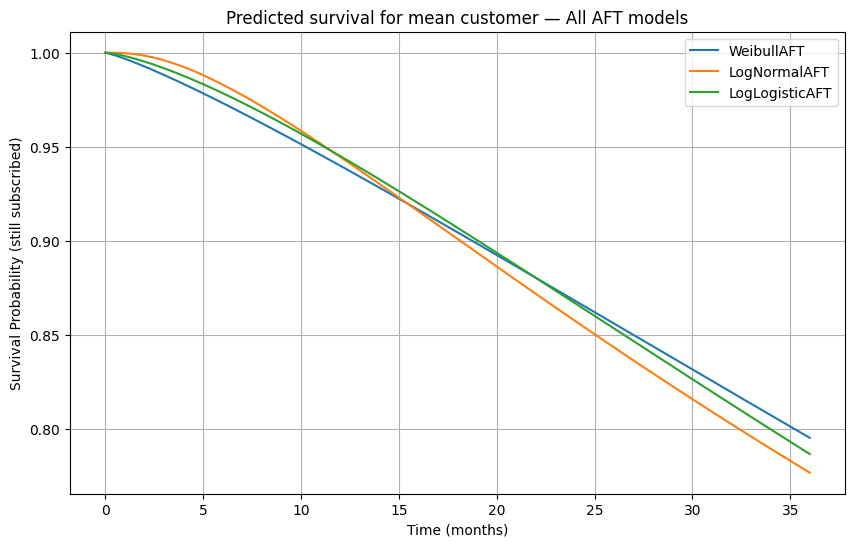


Best model by AIC: LogNormalAFT

Running backward elimination (keep significant features)...
Final features (18): ['age', 'address', 'income', 'region_Zone 2', 'region_Zone 3', 'marital_Unmarried', 'ed_Did not complete high school', 'ed_High school degree', 'ed_Post-undergraduate degree', 'ed_Some college', 'retire_Yes', 'gender_Male', 'voice_Yes', 'internet_Yes', 'forward_Yes', 'custcat_E-service', 'custcat_Plus service', 'custcat_Total service']
Final model summary:
                                            coef  exp(coef)  se(coef)  \
param  covariate                                                        
mu_    address                          0.042538   1.043456  0.008904   
       age                              0.032670   1.033209  0.007254   
       custcat_E-service                1.066401   2.904907  0.170532   
       custcat_Plus service             0.924929   2.521689  0.215751   
       custcat_Total service            1.198617   3.315528  0.250452   
       ed_Did n

In [8]:
results = run_workflow()


### Report

**Churn analysis and key drivers**

The LogNormal AFT model provided the best fit for predicting subscriber churn. Positive coefficients, such as Plus service E-service, higher age, and higher income—are associated with lower churn risk, while negative coefficients, like internet_Yes, voice_Yes, and marital_Unmarried—increase churn risk. This indicates that premium service subscribers and more established, higher-income customers are more likely to stay, whereas younger, unmarried, or basic-plan users are more prone to churn.

**Valuable segments and retention recommendations**

The most valuable segments are high-tenure customers on premium plans, with the highest CLV (~295 USD-311 USD). Low-tenure subscribers (0–17 months) are at higher risk and represent key targets for retention campaigns. A retention budget should focus on these at-risk, high-value subscribers, using targeted offers, loyalty programs, and proactive communication. Continuously monitoring subscriber features and updating survival models will help improve CLV predictions and guide effective retention strategies.